In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import io
from mpl_toolkits.mplot3d import Axes3D

import config

In [2]:
def PlotSpectraAndMean(Spectra, Wv, fignum):
    ### Spectra is NBands x NSamps
    mu = np.mean(Spectra, axis=1)
    print(np.shape(mu))
    plt.figure(fignum)
    plt.plot(Wv, Spectra, 'c')
    plt.plot(Wv, mu, 'r')
    plt.show()
    return mu

In [3]:
filename   = os.path.join(config.RSDI_DATASET_DIR, 'OSBSTinyIm.mat')
ImDict     = io.loadmat(filename)
OSBSTinyIm = ImDict['OSBSTinyIm']
TinySize   = np.shape(OSBSTinyIm)

NRows, NCols, NBands = OSBSTinyIm.shape
print('{0:4d} {1:4d} {2:4d}'.format(NRows, NCols, NBands))

  62  194  346


In [4]:
OSBSTinyIm.shape

(62, 194, 346)

Now we can extract wavelengths.

(346, 1)


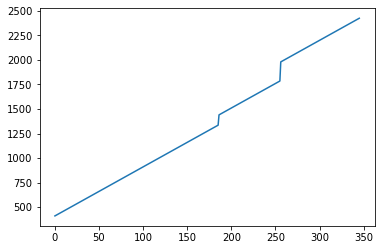

In [5]:
### LOAD WAVELENGTHS WITH WATER BANDS ###
### AND BAD BEGINNING AND ENDING BANDS REMOVED ###
Wv = io.loadmat(os.path.join(config.RSDI_DATASET_DIR,'NEONWvsNBB.mat'))
Wv = Wv['NEONWvsNBB']
print(np.shape(Wv))

plt.figure(1)
plt.plot(range(346), Wv)
plt.show()

Let's load indices for Red, Green, and Blue for NEON hyperspectral data.

In [6]:
### HAVE TO SUBTRACT AN OFFSET BECAUSE OF BAD BAND ###
### REMOVAL AND 0-BASED Python vs 1-Based MATLAB   ###
Offset     = 7

### LOAD & PRINT THE INDICES FOR THE COLORS   ###
### AND DIG THEM OUT OF MANY LAYERS OF ARRAYS ###
NEONColors = io.loadmat(os.path.join(config.RSDI_DATASET_DIR,'NEONColors.mat'))
NEONRed    = NEONColors['NEONRed'].item()
NEONGreen  = NEONColors['NEONGreen'].item()
NEONBlue   = NEONColors['NEONBlue'].item()
NEONNir    = NEONColors['NEONNir'].item()
NEONRed    = NEONRed-Offset
NEONGreen  = NEONGreen-Offset
NEONBlue   = NEONBlue-Offset
NEONNir    = NEONNir-Offset
print('Indices:     {0:4d} {1:4d} {2:4d} {3:4d}'.format(NEONRed, NEONGreen, NEONBlue, NEONNir))

### CONVERT THE INDICES TO WAVELENGTHS ###
NEONRedWv    = Wv[NEONRed].item()
NEONGreenWv  = Wv[NEONGreen].item()
NEONBlueWv   = Wv[NEONBlue].item()
NEONNirWv    = Wv[NEONNir].item()
print('Wavelengths: {0:4d} {1:4d} {2:4d} {3:4d}'.format(NEONRedWv, NEONGreenWv, NEONBlueWv, NEONNirWv))

Indices:       47   25    6  119
Wavelengths:  645  535  440 1005


Now we can make a color image and display it

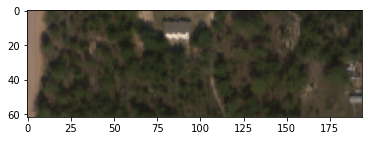

In [7]:
RGBIm = OSBSTinyIm[:, :, [NEONRed, NEONGreen, NEONBlue]]
RGBIm = np.sqrt(RGBIm)
plt.figure(2)
plt.imshow(RGBIm)
plt.show()

Now let's turn the image into a sequence of vectors so we can use matrix algebra

In [8]:
### HAVE TO TAKE INTO ACCOUNT DIFFERENCES BETWEEN Python AND Matlab ###
### Python USES THE    C     PROGRAMMING LANGUAGE ORDERING ###
### MATLAB USERS THE FORTRAN PROGRAMMING LANGUAGE ORDERING ###
### Python WOULD RESHAPE BY REFERENCE AND MATLAB BY VALUE  ###
### THEREFORE, WE NEED TO COPY THE VALUES EXPLICITLY       ###
TinyVecs = OSBSTinyIm.reshape(NRows*NCols, NBands, order='F').copy()

### MATLAB TREATS THE ROWS AS DATA SAMPLES ###
### np  TREATS THE COLS AS DATA SAMPLES ###
TinyVecs = np.transpose(TinyVecs) # No estoy de acuerdo
NSamps   = np.shape(TinyVecs)[1]
np.shape(TinyVecs)

(346, 12028)

(346,)


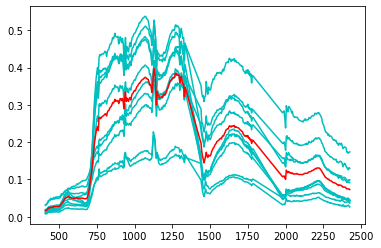

In [9]:
### EXERCISE
SpecIndices = range(1000, 2000, 100)
SomeSpectra = TinyVecs[:, range(1000, 2000, 100)]
mymu        = PlotSpectraAndMean(SomeSpectra, Wv, 3)

Let's plot some spectra

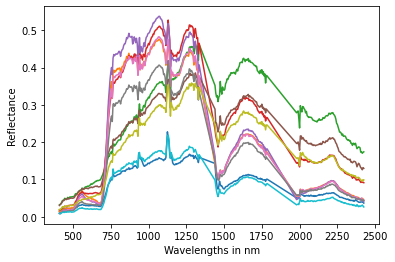

In [10]:
### Indices of Spectra to Try ###
### SpecIndices = range(0, 1000, 100) ###
SpecIndices = range(1000, 2000, 100)
SomeSpectra = TinyVecs[:, range(1000, 2000, 100)]
plt.figure(3)
plt.plot(Wv, SomeSpectra)
plt.xlabel('Wavelengths in nm')
plt.ylabel('Reflectance')
plt.show()

Compute the Average Spectrum and plot it

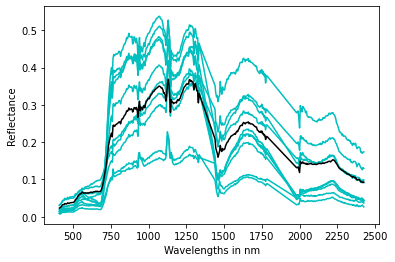

In [11]:
mu = np.mean(TinyVecs, axis=1)
plt.figure(4)
plt.plot(Wv, SomeSpectra, 'c')
plt.plot(Wv, mu, 'k')
plt.xlabel('Wavelengths in nm')
plt.ylabel('Reflectance')
plt.show()

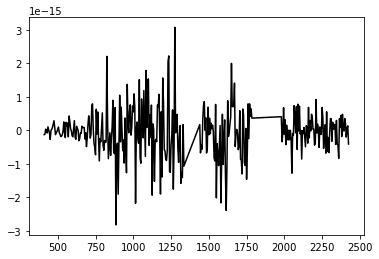

In [12]:
TinyVecsZ = np.zeros((NBands, NSamps))
for n in range(NSamps):
    TinyVecsZ[range(NBands),n]= TinyVecs[(range(NBands), n)]-mu

muz = np.mean(TinyVecsZ, axis=1)
plt.figure(5)
plt.plot(Wv, muz, 'k')
#plt.ylim(-1,1)
plt.show()


Let's calculate the covariance.

(346, 346)


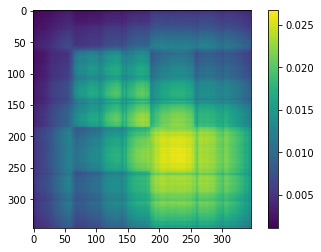

In [13]:
C = np.cov(TinyVecs)
print(np.shape(C))
plt.figure(6)
plt.imshow(C)
plt.colorbar()
plt.show()

In [14]:
# PRINT OUT SOME "AMPLIFIED" COVARIANCE VALUES %%%
for cn in range(0, 50,5):
    w = int(Wv[cn])
    if cn==0:
        print("     ", end=" ")
    else:
        print('{0:5d}'.format(w), end=" ")
print('\n')


for rn in range(5, 50, 5):
    w = int(Wv[rn])
    print('{0:5d}'.format(w), end=" ")
    for cn in range(5,50,5):
        CovVal = int(100000*C[rn, rn])
        print('{0:5d}'.format(CovVal), end=" ")
    print('\n')

        435   460   485   510   535   560   585   610   635 

  435   166   166   166   166   166   166   166   166   166 

  460   198   198   198   198   198   198   198   198   198 

  485   226   226   226   226   226   226   226   226   226 

  510   245   245   245   245   245   245   245   245   245 

  535   289   289   289   289   289   289   289   289   289 

  560   360   360   360   360   360   360   360   360   360 

  585   428   428   428   428   428   428   428   428   428 

  610   479   479   479   479   479   479   479   479   479 

  635   544   544   544   544   544   544   544   544   544 



Notice that there are no negative values. Why?

What if we normalize the vectors to have Norm 1 (a common strategy).

In [15]:
import numpy as np
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin

class Norm1Transform(TransformerMixin, BaseEstimator):
    '''
        Normalize the vector to have Norm 1
    '''
    def __init__(self, n_features_to_select=None):
        super(Norm1Transform, self).__init__()

    def fit(self, X, y=None):
        self.norms_ = np.sqrt(np.sum(X**2), axis=0)
        return self

    def transform(self, X, y=None, **kwargs):
        check_is_fitted(self)
        return X[:, ]
        return X[:, self.selected_features_idx]

In [16]:
((TinyVecs*TinyVecs) == TinyVecs**2).all()

True

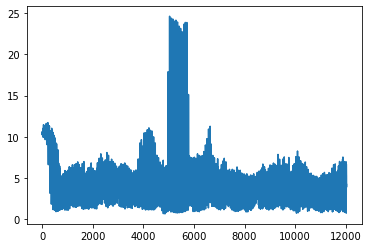

In [17]:
Norms = np.sqrt(np.sum(TinyVecs*TinyVecs, axis=0))
plt.figure(7)
plt.plot(Norms)
### Too many Norms.  How do we fix?
plt.show()

In [18]:
print(TinyVecs.shape)
print(Norms.shape)

(346, 12028)
(12028,)


In [19]:
print(np.shape(Norms))
print(np.shape(TinyVecs))

(12028,)
(346, 12028)


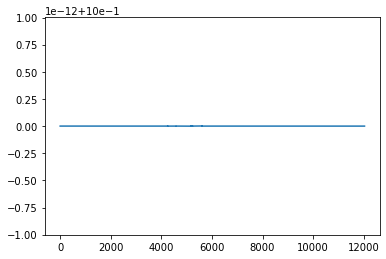

1.000000 1.000000


In [20]:
### Allocate Memory
TinyVecsNorm = np.zeros((NBands, NSamps))
for samp in range(NSamps):
    NormSamp = Norms[samp]
    for band in range(NBands):
        TinyVecsNorm[band, samp] = TinyVecs[band,samp]/NormSamp
        
Norms1 = np.sqrt(np.sum(TinyVecsNorm*TinyVecsNorm, axis=0))
plt.figure(7)
plt.plot(Norms1)
plt.show()
BigNorm = np.max(Norms1)
LitNorm = np.min(Norms1)
print('{0:4f} {1:4f}'.format(BigNorm, LitNorm))
### Too many Norms.  How do we fix?

In [21]:
Norms1

array([1., 1., 1., ..., 1., 1., 1.])

(346,)


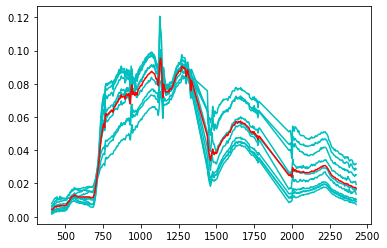

In [22]:
### EXERCISE
SpecIndices     = range(1000, 2000, 100)
SomeSpectraNorm = TinyVecsNorm[:, range(1000, 2000, 100)]
MuNorm          = PlotSpectraAndMean(SomeSpectraNorm, Wv, 3)

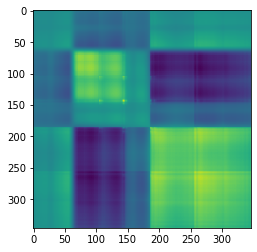

In [23]:
CNorm = np.cov(TinyVecsNorm)
plt.figure()
plt.imshow(CNorm)
# plt.colorbar()
plt.show()

In [24]:
# PRINT OUT SOME "AMPLIFIED" COVARIANCE VALUES %%%
for cn in range(0, 50,5):
    w = int(Wv[cn])
    if cn==0:
        print("     ", end=" ")
    else:
        print('{0:5d}'.format(w), end=" ")
print('\n')


for rn in range(5, 50, 5):
    w = int(Wv[rn])
    print('{0:5d}'.format(w), end=" ")
    for cn in range(5,50,5):
        CovVal = int(10000000*CNorm[rn, rn])
        print('{0:5d}'.format(CovVal), end=" ")
    print('\n')


        435   460   485   510   535   560   585   610   635 

  435   253   253   253   253   253   253   253   253   253 

  460   269   269   269   269   269   269   269   269   269 

  485   289   289   289   289   289   289   289   289   289 

  510   284   284   284   284   284   284   284   284   284 

  535   263   263   263   263   263   263   263   263   263 

  560   303   303   303   303   303   303   303   303   303 

  585   397   397   397   397   397   397   397   397   397 

  610   455   455   455   455   455   455   455   455   455 

  635   523   523   523   523   523   523   523   523   523 



In [31]:
print(np.shape(TinyVecs))
print(NEONNir)
print(NEONRed)
NIRVals  = TinyVecs[NEONNir, range(NSamps)]
RedVals  = TinyVecs[NEONRed, range(NSamps)]
NDVIVals = (NIRVals-RedVals)/(NIRVals+RedVals)
np.shape(NDVIVals)
NDVIIm   = np.reshape(NDVIVals,(NRows, NCols),order='F')

(346, 12028)
119
47


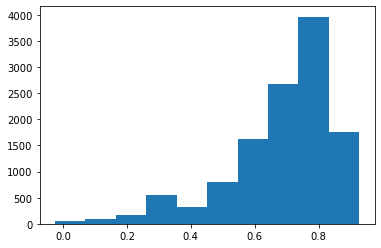

In [26]:
plt.figure()
plt.hist(NDVIVals)
plt.show()

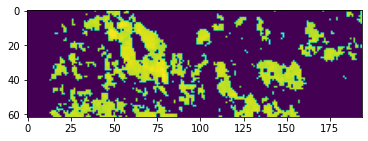

In [27]:
HiNDVI = NDVIIm*(NDVIIm>0.8)
plt.figure()
plt.imshow(HiNDVI)
plt.show()

In [28]:
# plt.figure()
# plt.plot(nonzero(NDVIVals>0.8))
# plt.show()
VegIndices = np.nonzero(NDVIVals>0.8)
# print(VegIndices[0])
print(np.shape(VegIndices))
# print(np.shape(TinyVecs))
VegSpectra = TinyVecs[:, VegIndices[0]]
print(np.shape(VegSpectra))

(1, 3136)
(346, 3136)


In [29]:
VegSpectra

array([[0.0133, 0.012 , 0.012 , ..., 0.007 , 0.006 , 0.0059],
       [0.0131, 0.0109, 0.0137, ..., 0.0075, 0.0056, 0.0061],
       [0.0141, 0.0128, 0.014 , ..., 0.0089, 0.0057, 0.0077],
       ...,
       [0.0394, 0.0378, 0.0429, ..., 0.0246, 0.0211, 0.0327],
       [0.0432, 0.0366, 0.0422, ..., 0.0223, 0.0208, 0.0281],
       [0.0375, 0.0346, 0.0388, ..., 0.0209, 0.0184, 0.0261]])

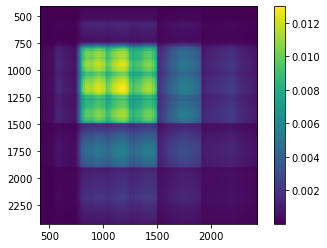

In [30]:
CVeg = np.cov(VegSpectra)
plt.figure(9)
# plt.imshow()
plt.imshow(CVeg,extent=(np.amin(Wv), np.amax(Wv),np.amax(Wv), np.amin(Wv)))
plt.colorbar()
plt.show()

In [42]:
VegSpectra.shape

(346, 3136)

# PCA

OK, let's do PCA

Recall that TinyVecs is the mean-subtracted version of the original spectra.

In [50]:
# selected_data = TinyVecs
selected_data = TinyVecsNorm

C   = np.cov(selected_data)
D,V = linalg.eig(C)
D   = D.real
print(np.shape(D))
print(np.shape(V))
print(selected_data.shape)
print(V[0,0])

(346,)
(346, 346)
(346, 12028)
0.01284138169050587


(346,)
(346,)


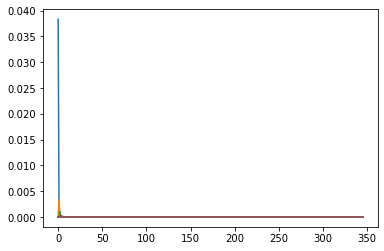

In [51]:
plt.figure(10)
print(D.shape)
DiagD = np.diag(D)
print(D.shape)
plt.plot(DiagD)
#Exercise
#plt.plot(D[range(10)])
#plt.plot(D[range(10, 30, 10)])
plt.show()

In [52]:
TinyVecsPCA = np.dot(V.T, selected_data)
PCACovar    = np.cov(TinyVecsPCA)
D,V         = linalg.eig(C)
D           = D.real
print(D.shape)
print(PCACovar.shape)
for r in range(10):
    print('{0:5f} {1:5f}'.format(D[r], PCACovar[r,r]))
print()
for r in range(10):
    for c in range(10):
        NextVal = int(10000*PCACovar[r,c])
        print('{0:5d}'.format(NextVal), end=" ")
    print('\n')
# #Delta       = np.sum(np.sum((PCACovar-D), axis=0), axis=0)
# print(Delta)
# plt.figure(11)
# plt.plot(np.diag(PCACovar))
# plt.show()

(346,)
(346, 346)
0.038306 0.038306
0.003342 0.003342
0.001098 0.001098
0.000309 0.000309
0.000121 0.000121
0.000113 0.000113
0.000083 0.000083
0.000034 0.000034
0.000029 0.000029
0.000025 0.000025

  383     0     0     0     0     0     0     0     0     0 

    0    33     0     0     0     0     0     0     0     0 

    0     0    10     0     0     0     0     0     0     0 

    0     0     0     3     0     0     0     0     0     0 

    0     0     0     0     1     0     0     0     0     0 

    0     0     0     0     0     1     0     0     0     0 

    0     0     0     0     0     0     0     0     0     0 

    0     0     0     0     0     0     0     0     0     0 

    0     0     0     0     0     0     0     0     0     0 

    0     0     0     0     0     0     0     0     0     0 



In [53]:
D

array([3.83061132e-02, 3.34230064e-03, 1.09769206e-03, 3.08603305e-04,
       1.21347272e-04, 1.13383674e-04, 8.30578464e-05, 3.39188740e-05,
       2.93614839e-05, 2.45925469e-05, 1.98742376e-05, 1.10604103e-05,
       1.00161143e-05, 8.77752186e-06, 7.76482771e-06, 6.02670485e-06,
       4.44514393e-06, 3.52698582e-06, 2.91940041e-06, 2.29037473e-06,
       1.92075102e-06, 1.52838854e-06, 1.48469415e-06, 1.30248746e-06,
       1.20570563e-06, 1.07331365e-06, 1.05198124e-06, 9.08573074e-07,
       8.57545361e-07, 8.34122357e-07, 7.54229075e-07, 7.10316058e-07,
       6.53114782e-07, 6.41711133e-07, 6.17179407e-07, 5.62181536e-07,
       5.50014889e-07, 5.32384606e-07, 5.17377599e-07, 4.85051740e-07,
       4.69623217e-07, 4.54015008e-07, 4.45545108e-07, 4.28437037e-07,
       4.24868347e-07, 4.12971745e-07, 3.99684739e-07, 3.84636619e-07,
       3.76090026e-07, 3.70368645e-07, 3.60668096e-07, 3.44329885e-07,
       3.35166151e-07, 3.30281279e-07, 3.13935797e-07, 3.03078647e-07,
      

Notice that the values on the diagonal are the variances of each coordinate in the PCA transformed data. They drop off rapidly which is why one can reduce dimensionality by discarding components that have low variance. Also, notice that the diagonal matrix D produce by diagonalizing the covariance of x is the covariance of y = PCA(x).

If the data are Gaussian, then the coordinates of y are uncorrelated and independent. If not, then only uncorrelated.

Let's pull out the first 3 dimensions and plot them

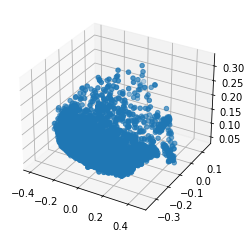

In [54]:
# %matplotlib widget
fig = plt.figure(13)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(TinyVecsPCA[0,range(NSamps)],TinyVecsPCA[1,range(NSamps)],TinyVecsPCA[2,range(NSamps)], marker='o')
plt.show()

In [55]:
TinyVecsPCA.shape

(346, 12028)

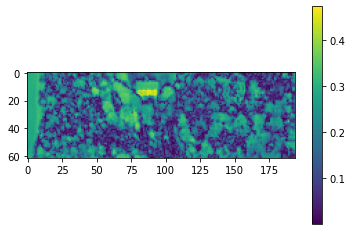

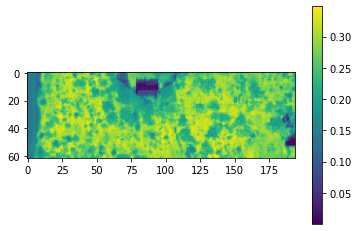

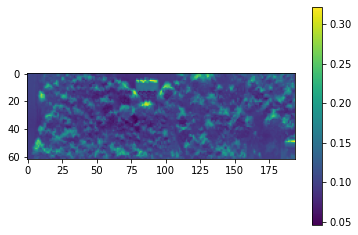

In [56]:
for coord in range(3):
    P1 = TinyVecsPCA[coord, :]
    PCAIm      = np.reshape(P1, (NRows, NCols), order='F')
    plt.figure(14+coord)
    plt.imshow(np.abs(PCAIm))
    plt.colorbar()
    plt.show()

# plt.colorbar()
# plt.show()

In [41]:
PCAIm.min()

0.046440713344387534

In [ ]:
TinyVecsPCA.shape